# BookScrape: Web Scraping, Price Prediction, and Category Clustering for Book Analysis

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
categories = {
    'Travel': 'http://books.toscrape.com/catalogue/category/books/travel_2/index.html',
    'Mystery': 'http://books.toscrape.com/catalogue/category/books/mystery_3/index.html',
    'Historical Fiction': 'http://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html',
    'Sequential Art': 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html',
    'Classics' : 'http://books.toscrape.com/catalogue/category/books/classics_6/index.html',
    'Philosophy': 'http://books.toscrape.com/catalogue/category/books/philosophy_7/index.html',
    'Romance': 'http://books.toscrape.com/catalogue/category/books/romance_8/index.html',
    'Womens Fiction' : 'http://books.toscrape.com/catalogue/category/books/womens-fiction_9/index.html',
    'Fiction' : 'http://books.toscrape.com/catalogue/category/books/fiction_10/index.html',
    'Childrens' : 'http://books.toscrape.com/catalogue/category/books/childrens_11/index.html',
    'Religion' : 'http://books.toscrape.com/catalogue/category/books/religion_12/index.html',
    'Nonfiction' : 'http://books.toscrape.com/catalogue/category/books/nonfiction_13/index.html',
    'Music' : 'http://books.toscrape.com/catalogue/category/books/music_14/index.html',
    'Default':'http://books.toscrape.com/catalogue/category/books/default_15/index.html',
    'Science Fiction':'http://books.toscrape.com/catalogue/category/books/science-fiction_16/index.html',
    'Sports and Games':'http://books.toscrape.com/catalogue/category/books/sports-and-games_17/index.html',
    'Fantasy':'http://books.toscrape.com/catalogue/category/books/fantasy_19/index.html',
    'New Adult':'http://books.toscrape.com/catalogue/category/books/new-adult_20/index.html',
    'Young Adult':'http://books.toscrape.com/catalogue/category/books/young-adult_21/index.html'
}

# Create an empty dictionary to store book URLs by category
book_urls_by_category = {}

# Iterate over each category
for category, url in categories.items():
    # Send an HTTP GET request to the category page
    response = requests.get(url)

    # Create a BeautifulSoup object to parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all the book containers on the category page
    books = soup.find_all('article', class_='product_pod')

    # Create an empty list to store book URLs
    book_urls = []

    # Iterate over each book container
    for book in books:
        # Extract the book URL
        book_url = book.h3.a['href']
        book_url = re.sub(r'\.\./', '', book_url)
        book_url = 'http://books.toscrape.com/catalogue/' + book_url

        # Append the book URL to the list
        book_urls.append(book_url)

    # Add the book URLs to the dictionary for the current category
    book_urls_by_category[category] = book_urls

# Store the book URLs by category in a JSON file
with open('book_urls_by_category.json', 'w') as f:
    json.dump(book_urls_by_category, f, indent=4)

print("Book URLs scraped and saved to book_urls_by_category.json.")

Book URLs scraped and saved to book_urls_by_category.json.


In [3]:
# Load the book URLs by category from the JSON file
with open('book_urls_by_category.json', 'r') as f:
    book_urls_by_category = json.load(f)

# Create an empty list to store book details
book_details = []

# Iterate over each category and its book URLs
for category, book_urls in book_urls_by_category.items():
    # Iterate over each book URL in the category
    for book_url in book_urls:
        # Send an HTTP GET request to the book URL
        response = requests.get(book_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract the desired information for the book
        title = soup.find('h1').text.strip()
        price_element = soup.find('p', class_='price_color')
        price = price_element.text.strip()[1:] if price_element else ''
        availability_element = soup.find('p', class_='instock availability')
        availability = availability_element.text.strip() if availability_element else ''
        status = "In stock" if "in stock" in availability.lower() else "Out of stock"
        quantity = availability.split('(')[-1].split()[0] if availability else ''
        rating_element = soup.find('p', class_='star-rating')
        rating = rating_element['class'][1] if rating_element else ''
        product_type_element = soup.find('th', text='Product Type')
        product_type = product_type_element.find_next('td').text.strip() if product_type_element else ''
        num_reviews_element = soup.find('th', text='Number of reviews')
        num_reviews = num_reviews_element.find_next('td').text.strip() if num_reviews_element else ''
        category_element = soup.find('ul', class_='breadcrumb')
        category = category_element.find_all('li')[-2].text.strip() if category_element else ''

        # Create a dictionary for the book and append it to the list
        book_details.append({
            'Title': title,
            'Price': price,
            'Status': status,
            'Quantity': quantity,
            'Rating': rating,
            'Product Type': product_type,
            'Number of Reviews': num_reviews,
            'Category': category
        })

# Store the book details in a JSON file
with open('book_details.json', 'w') as f:
    json.dump(book_details, f, indent=4)

print("Data scraped and saved to book_details.json.")

Data scraped and saved to book_details.json.


In [4]:
df = pd.read_json('book_details.json')
df.head()

,Title,Price,Status,Quantity,Rating,Product Type,Number of Reviews,Category
0,It's Only the Himalayas,45.17,In stock,19,Two,Books,0,Travel
1,Full Moon over Noah’s Ark: An Odyssey to Mount...,49.43,In stock,15,Four,Books,0,Travel
2,See America: A Celebration of Our National Par...,48.87,In stock,14,Three,Books,0,Travel
3,Vagabonding: An Uncommon Guide to the Art of L...,36.94,In stock,8,Two,Books,0,Travel
4,Under the Tuscan Sun,37.33,In stock,7,Three,Books,0,Travel


In [5]:
# Create a new column "Book ID" with numeric IDs for each book
df['Book ID'] = range(1, len(df)+1)

# Format the "Book ID" column to have leading zeros
df['Book ID'] = df['Book ID'].apply(lambda x: f'{x:04d}')

# Display the updated DataFrame
print(df.head())

                                               Title  Price    Status  \
0                            It's Only the Himalayas  45.17  In stock   
1  Full Moon over Noah’s Ark: An Odyssey to Mount...  49.43  In stock   
2  See America: A Celebration of Our National Par...  48.87  In stock   
3  Vagabonding: An Uncommon Guide to the Art of L...  36.94  In stock   
4                               Under the Tuscan Sun  37.33  In stock   

   Quantity Rating Product Type  Number of Reviews Category Book ID  
0        19    Two        Books                  0   Travel    0001  
1        15   Four        Books                  0   Travel    0002  
2        14  Three        Books                  0   Travel    0003  
3         8    Two        Books                  0   Travel    0004  
4         7  Three        Books                  0   Travel    0005  


In [6]:
df['Rating'] = df['Rating'].map({"One":1,"Two":2,"Three":3,"Four":4,"Five":5})
df['Status'] = df['Status'].map({'In stock':1,"Out of stock":0})

In [7]:
df['Category'].unique()

array(['Travel', 'Mystery', 'Historical Fiction', 'Sequential Art',
       'Classics', 'Philosophy', 'Romance', 'Womens Fiction', 'Fiction',
       'Childrens', 'Religion', 'Nonfiction', 'Music', 'Default',
       'Science Fiction', 'Sports and Games', 'Fantasy', 'New Adult',
       'Young Adult'], dtype=object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              305 non-null    object 
 1   Price              305 non-null    float64
 2   Status             305 non-null    int64  
 3   Quantity           305 non-null    int64  
 4   Rating             305 non-null    int64  
 5   Product Type       305 non-null    object 
 6   Number of Reviews  305 non-null    int64  
 7   Category           305 non-null    object 
 8   Book ID            305 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 21.6+ KB


In [9]:
df.describe()

,Price,Status,Quantity,Rating,Number of Reviews
count,305.000000,305.0,305.000000,305.000000,305.0
mean,35.484197,1.0,11.213115,2.872131,0.0
std,13.958230,0.0,5.835223,1.421190,0.0
min,10.160000,1.0,1.000000,1.000000,0.0
25%,23.150000,1.0,5.000000,2.000000,0.0
50%,35.670000,1.0,14.000000,3.000000,0.0
75%,47.670000,1.0,16.000000,4.000000,0.0
max,59.990000,1.0,20.000000,5.000000,0.0


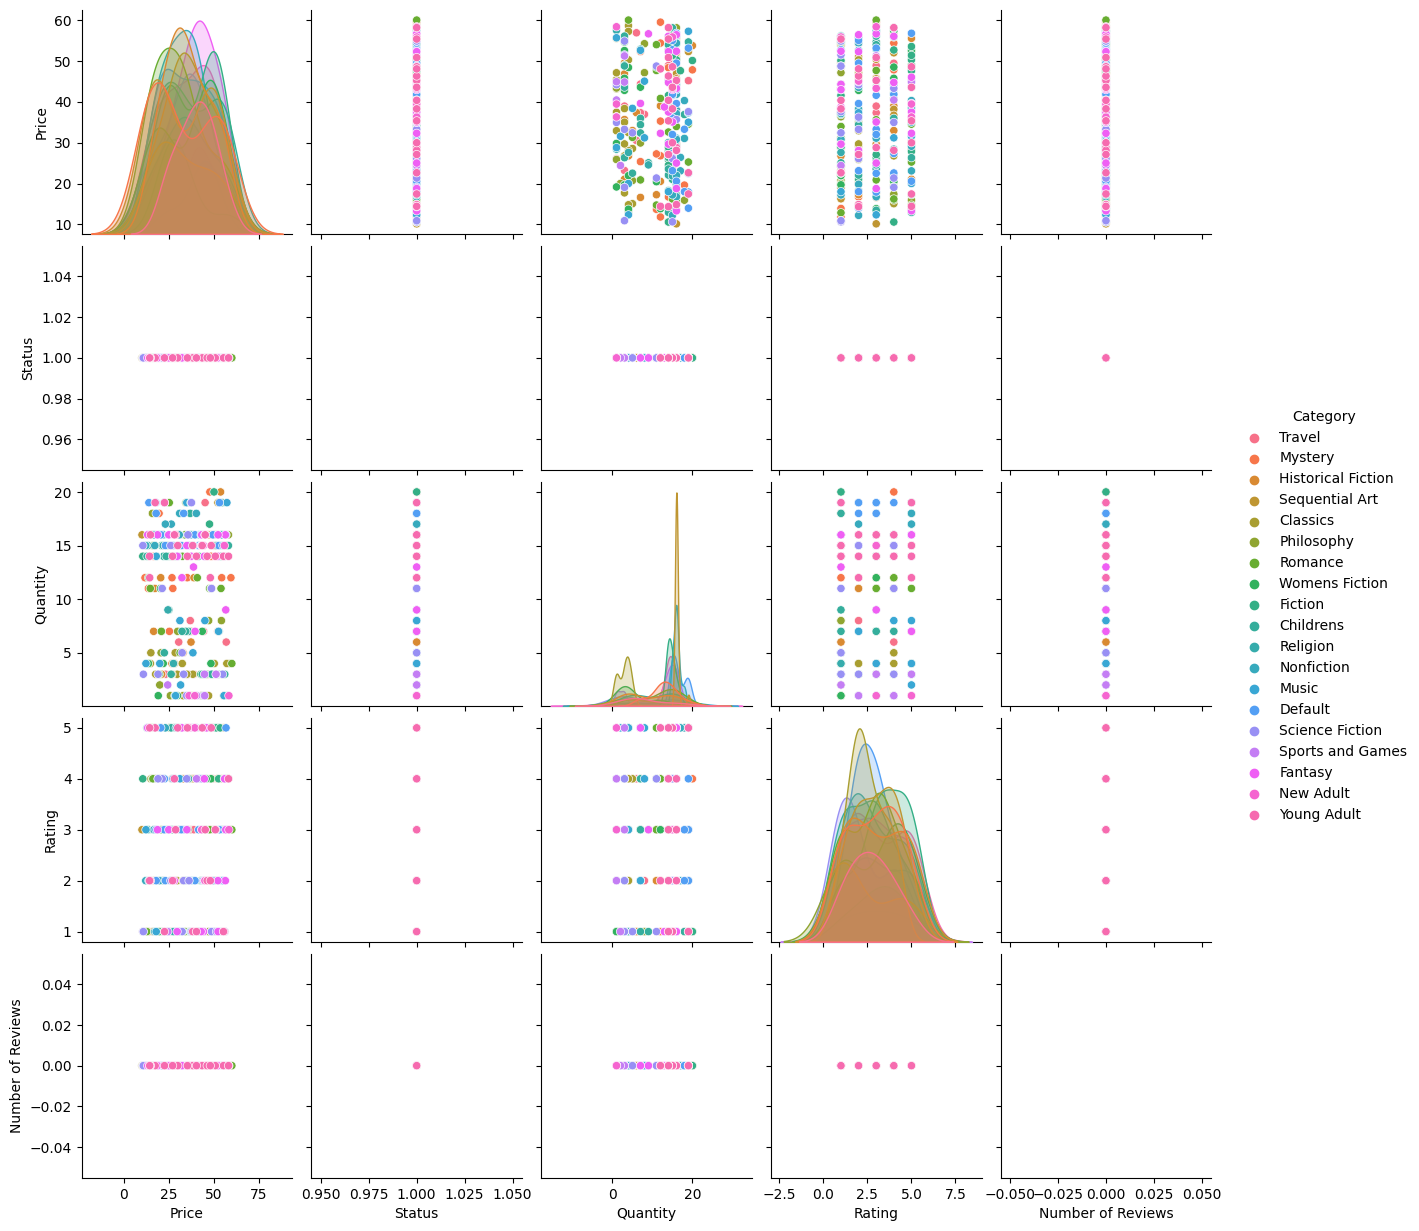

In [10]:
sns.pairplot(df,kind='scatter',hue='Category')

In [11]:
categories = ['Travel', 'Mystery', 'Historical Fiction', 'Sequential Art', 'Classics',
              'Philosophy', 'Romance', 'Womens Fiction', 'Fiction', 'Childrens',
              'Religion', 'Nonfiction', 'Music', 'Default', 'Science Fiction',
              'Sports and Games', 'Fantasy', 'New Adult', 'Young Adult']

df['Category ID'] = pd.factorize(df['Category'])[0]

df

,Title,Price,Status,Quantity,Rating,Product Type,Number of Reviews,Category,Book ID,Category ID
0,It's Only the Himalayas,45.17,1,19,2,Books,0,Travel,0001,0
1,Full Moon over Noah’s Ark: An Odyssey to Mount...,49.43,1,15,4,Books,0,Travel,0002,0
2,See America: A Celebration of Our National Par...,48.87,1,14,3,Books,0,Travel,0003,0
3,Vagabonding: An Uncommon Guide to the Art of L...,36.94,1,8,2,Books,0,Travel,0004,0
4,Under the Tuscan Sun,37.33,1,7,3,Books,0,Travel,0005,0
...,...,...,...,...,...,...,...,...,...,...
300,Don't Get Caught,55.35,1,14,1,Books,0,Young Adult,0301,18
301,Catching Jordan (Hundred Oaks),50.83,1,14,3,Books,0,Young Adult,0302,18
302,Aristotle and Dante Discover the Secrets of th...,58.14,1,14,4,Books,0,Young Adult,0303,18
303,The Epidemic (The Program 0.6),14.44,1,12,5,Books,0,Young Adult,0304,18


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              305 non-null    object 
 1   Price              305 non-null    float64
 2   Status             305 non-null    int64  
 3   Quantity           305 non-null    int64  
 4   Rating             305 non-null    int64  
 5   Product Type       305 non-null    object 
 6   Number of Reviews  305 non-null    int64  
 7   Category           305 non-null    object 
 8   Book ID            305 non-null    object 
 9   Category ID        305 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 24.0+ KB


In [13]:
X = df.drop(['Price','Title','Product Type','Number of Reviews','Category'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [14]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 227.14637132679067
R^2 Score: -0.0033993365572135836


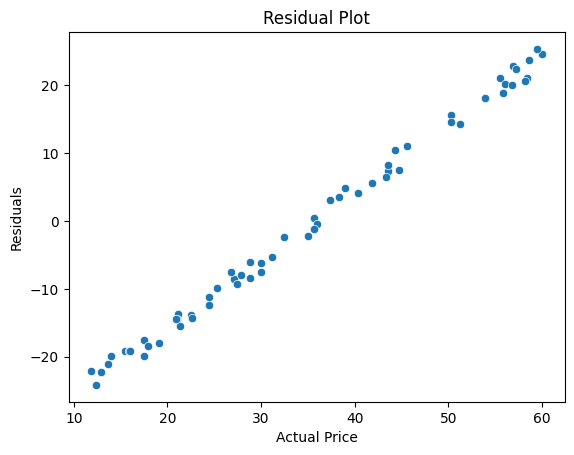

In [15]:
residuals = y_test - y_pred

# Plot the residuals
sns.scatterplot(x=y_test, y=residuals)
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

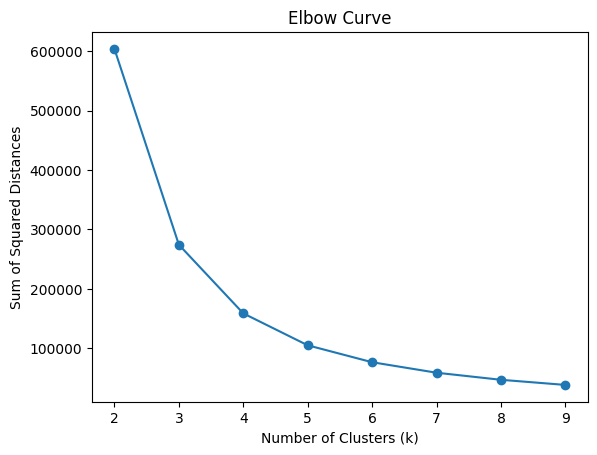

In [16]:
k_values = range(2, 10)
inertia = []

# Compute the sum of squared distances for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve')
plt.show()

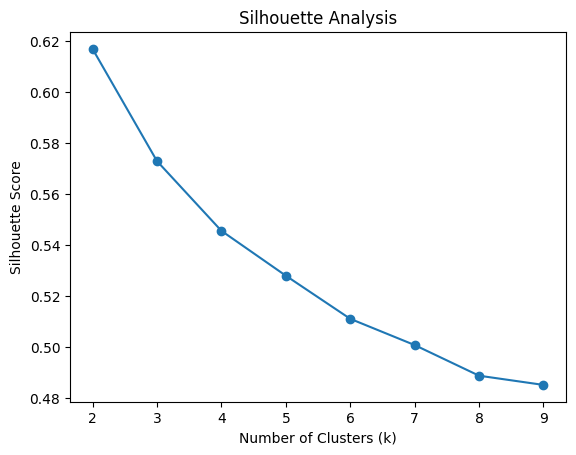

In [17]:
k_values = range(2, 10)
silhouette_scores = []

# Compute the silhouette score for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [18]:
# Convert the book titles to a list
titles = df['Title'].tolist()

# Initialize a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the titles into TF-IDF vectors
tfidf_matrix = vectorizer.fit_transform(titles)

# Perform K-means clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

# Get the predicted cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
df['Cluster'] = cluster_labels

# Display the updated DataFrame
print(df.head())

                                               Title  Price  Status  Quantity  \
0                            It's Only the Himalayas  45.17       1        19   
1  Full Moon over Noah’s Ark: An Odyssey to Mount...  49.43       1        15   
2  See America: A Celebration of Our National Par...  48.87       1        14   
3  Vagabonding: An Uncommon Guide to the Art of L...  36.94       1         8   
4                               Under the Tuscan Sun  37.33       1         7   

   Rating Product Type  Number of Reviews Category Book ID  Category ID  \
0       2        Books                  0   Travel    0001            0   
1       4        Books                  0   Travel    0002            0   
2       3        Books                  0   Travel    0003            0   
3       2        Books                  0   Travel    0004            0   
4       3        Books                  0   Travel    0005            0   

   Cluster  
0        3  
1        1  
2        1  
3        3

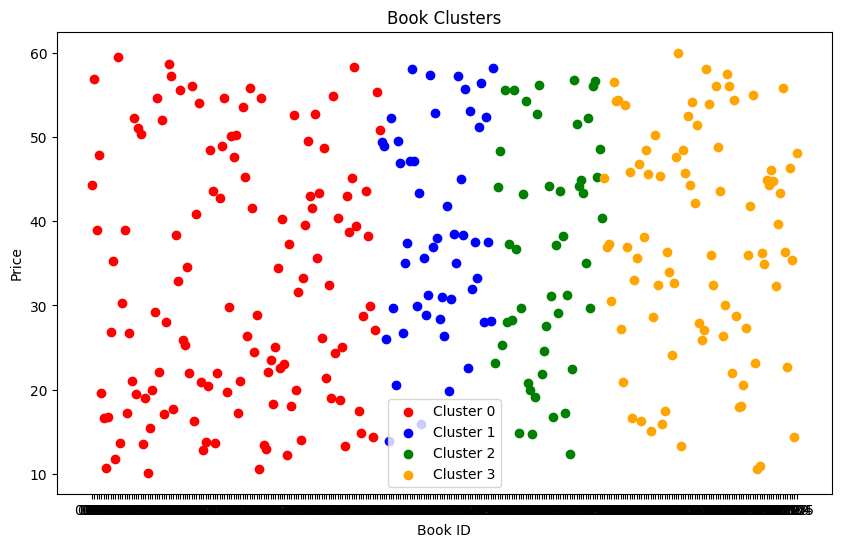

In [19]:
colors = ['red', 'blue', 'green', 'orange'] #, 'purple']

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 6))
for cluster_id, color in zip(range(k), colors):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['Book ID'], cluster_data['Price'], color=color, label=f'Cluster {cluster_id}')

plt.xlabel('Book ID')
plt.ylabel('Price')
plt.title('Book Clusters')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eb0e073a-5cad-4437-b3c7-9cc8d69e82fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>